In [33]:
import os
import pickle
import torch
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from collections import defaultdict, Counter
from abc import ABC, abstractmethod
from sklearn.neighbors import NearestNeighbors
from sentence_transformers import SentenceTransformer 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

# Suppress sklearn parallel warning - usando a forma correta
warnings.filterwarnings('ignore', message='.*sklearn.utils.parallel.delayed.*', category=UserWarning)


In [34]:
class BaseRecommender(ABC):
    def __init__(self, name):
        self.name = name
        self.train_df = None
        
    @abstractmethod
    def fit(self, train_df):
        """Treina o modelo com os dados de treino."""
        pass
    
    @abstractmethod
    def recommend(self, author_id, top_n=10):
        """Retorna uma lista de author_ids recomendados."""
        pass

In [35]:
class TopologyRecommender(BaseRecommender):
    def __init__(self):
        super().__init__("Topology (Graph Coauthor)")
        self.graph = defaultdict(set)
        self.popular_authors = []
        
    def fit(self, train_df):
        self.train_df = train_df
        print(f"[{self.name}] Construindo grafo...")
        
        # Construção do Grafo
        for _, group in train_df.groupby('work_id'):
            authors = group['author_id'].tolist()
            if len(authors) > 1:
                for u, v in itertools.combinations(authors, 2):
                    self.graph[u].add(v)
        
        # Cálculo de Popularidade (para fallback)
        popularity_counter = Counter()
        for author, neighbors in self.graph.items():
            popularity_counter[author] = len(neighbors)
        self.popular_authors = [auth for auth, _ in popularity_counter.most_common()]
        print(f"[{self.name}] Grafo construído com {len(self.graph)} autores.")

    def recommend(self, author_id, top_n=10):
        recommendations = []
        current_coauthors = self.graph.get(author_id, set())
        
        # Determinar se top_n é negativo (modo mínimo)
        is_minimum_mode = top_n < 0
        target_n = abs(top_n) if is_minimum_mode else top_n
        
        # Lógica de Amigos em Comum (2 hops)
        if author_id in self.graph:
            candidates = []
            for neighbor in current_coauthors:
                neighbors_of_neighbor = self.graph.get(neighbor, set())
                for candidate in neighbors_of_neighbor:
                    if candidate != author_id and candidate not in current_coauthors:
                        candidates.append(candidate)
            
            # Se modo mínimo, pegar todos os amigos em comum
            # Se modo normal, limitar a top_n
            if is_minimum_mode:
                recommendations = [c[0] for c in Counter(candidates).most_common()]
            else:
                recommendations = [c[0] for c in Counter(candidates).most_common(top_n)]
        
        # Fallback: Populares
        # Se modo mínimo, garantir pelo menos target_n recomendações
        # Se modo normal, completar até top_n
        if len(recommendations) < target_n:
            for pop in self.popular_authors:
                if pop != author_id and pop not in recommendations and pop not in current_coauthors:
                    recommendations.append(pop)
                    if len(recommendations) >= target_n:
                        break
        
        # Se modo normal, limitar a top_n
        # Se modo mínimo, retornar todas (já garantimos pelo menos target_n)
        if not is_minimum_mode:
            return recommendations[:top_n]
        else:
            return recommendations


In [36]:
class HybridTopologyRecommender(BaseRecommender):
    def __init__(self, database_path='database_50k', qtd_pares_treino=5000):
        super().__init__("Hybrid (Topology + RF: common_neighbors + concept_overlap)")
        self.database_path = database_path
        self.qtd_pares_treino = qtd_pares_treino
        
        self.topology_model = TopologyRecommender()
        self.mapa_conceitos = defaultdict(set)
        self.rf_model = None
        self.features_used = ['common_neighbors', 'concept_overlap']
        
        # Carregar bases de dados na instanciação
        print(f"[{self.name}] Carregando bases de dados...")
        try:
            self.concepts_df = pd.read_csv(f'{self.database_path}/concepts.csv')
            self.concepts_filtrados = self.concepts_df[self.concepts_df['level'].isin([0, 1])]
            print(f"[{self.name}] Bases de dados carregadas: {len(self.concepts_filtrados)} conceitos (level 0-1).")
        except Exception as e:
            print(f"[{self.name}] AVISO: Erro ao carregar conceitos: {e}")
            self.concepts_df = None
            self.concepts_filtrados = None
        
    def fit(self, train_df):
        """
        Treina o modelo híbrido:
        1. Treina o modelo de topologia
        2. Mapeia conceitos dos autores
        3. Gera dataset de treino (pares positivos vs negativos)
        4. Treina RandomForest com common_neighbors + concept_overlap
        """
        self.train_df = train_df
        print(f"[{self.name}] Iniciando treinamento...")
        
        # 1. Treinar modelo de topologia
        print(f"[{self.name}] Treinando modelo de topologia...")
        self.topology_model.fit(train_df)
        
        # 2. Mapear conceitos dos autores
        self.concepts_filtrados = self.concepts_df[self.concepts_df['level'].isin([0, 1])]
        
        print(f"[{self.name}] Mapeando conceitos...")
        train_authors_works = train_df[['work_id', 'author_id']]
        author_concept_merge = train_authors_works.merge(
            self.concepts_filtrados[['work_id', 'concept_id']], 
            on='work_id'
        )
        
        for _, row in author_concept_merge.iterrows():
            self.mapa_conceitos[row['author_id']].add(row['concept_id'])
        print(f"[{self.name}] Conceitos mapeados para {len(self.mapa_conceitos)} autores.")
        
        # 3. Gerar dataset de treino
        print(f"[{self.name}] Gerando dataset de treino ({self.qtd_pares_treino} pares positivos + negativos)...")
        dataset_treino = []
        
        # 3.1. Pares positivos: autores que colaboraram
        obras_amostra = train_df['work_id'].unique()[:3000]
        pares_positivos = set()
        
        for work in obras_amostra:
            autores_obra = train_df[train_df['work_id'] == work]['author_id'].tolist()
            if len(autores_obra) > 1:
                for u, v in itertools.combinations(autores_obra, 2):
                    par = tuple(sorted([u, v]))
                    pares_positivos.add(par)
                    if len(pares_positivos) >= self.qtd_pares_treino:
                        break
            if len(pares_positivos) >= self.qtd_pares_treino:
                break
        
        # 3.2. Pares negativos: candidatos da topologia que não colaboraram
        pares_negativos = set()
        autores_list = list(self.topology_model.graph.keys())
        
        for u in autores_list[:3000]:
            # Usa recommend() com -10 para pegar todos os candidatos possíveis (mínimo 10)
            candidatos = self.topology_model.recommend(u, top_n=-10)
            # Limitar a 10 para manter consistência (os primeiros são os melhores da topologia)
            candidatos = candidatos[:10]
            for v in candidatos:
                par = tuple(sorted([u, v]))
                if par not in pares_positivos:
                    pares_negativos.add(par)
                if len(pares_negativos) >= self.qtd_pares_treino:
                    break
            if len(pares_negativos) >= self.qtd_pares_treino:
                break
        
        # 3.3. Extrair features para todos os pares
        for u, v in pares_positivos:
            dataset_treino.append(self._extrair_features(u, v, 1))
        
        for u, v in pares_negativos:
            dataset_treino.append(self._extrair_features(u, v, 0))
        
        df_ml = pd.DataFrame(dataset_treino)
        print(f"[{self.name}] Dataset criado: {len(df_ml)} linhas (Pos: {len(pares_positivos)}, Neg: {len(pares_negativos)})")
        
        # 4. Treinar RandomForest
        print(f"[{self.name}] Treinando RandomForest...")
        X_train = df_ml[self.features_used]
        y_train = df_ml['label']
        
        # Usar n_jobs=1 para evitar o warning do sklearn.utils.parallel
        # ou configurar o sklearn corretamente
        self.rf_model = RandomForestClassifier(
            n_estimators=50, 
            max_depth=5, 
            random_state=42, 
            n_jobs=1  # Evita warning do sklearn.utils.parallel
        )
        self.rf_model.fit(X_train, y_train)
        print(f"[{self.name}] Modelo treinado com sucesso!")
    
    def _extrair_features(self, u, v, label):
        """Extrai features para um par de autores."""
        # Topologia: reutiliza grafo do TopologyRecommender
        vizinhos_u = self.topology_model.graph.get(u, set())
        vizinhos_v = self.topology_model.graph.get(v, set())
        common_neighbors = len(vizinhos_u.intersection(vizinhos_v))
        
        # Semântica (conceitos)
        concept_overlap = len(self.mapa_conceitos.get(u, set()).intersection(
            self.mapa_conceitos.get(v, set())
        ))
        
        return {
            'common_neighbors': common_neighbors,
            'concept_overlap': concept_overlap,
            'label': label
        }
    
    def recommend(self, author_id, top_n=10):
        """
        Recomenda autores usando abordagem híbrida:
        1. Topologia gera candidatos (recall alto)
        2. RandomForest re-ranqueia os candidatos
        """
        # Determinar se top_n é negativo (modo mínimo)
        is_minimum_mode = top_n < 0
        target_n = abs(top_n) if is_minimum_mode else top_n
        
        # 1. Gerar candidatos via topologia (busca expandida) - usa recommend() com valor negativo
        # Valor negativo pega todos os candidatos possíveis com no mínimo target_n * 3
        search_limit = target_n * 3
        candidatos = self.topology_model.recommend(author_id, top_n=-search_limit)
        
        if not candidatos:
            # Fallback: reutiliza método do TopologyRecommender
            return self.topology_model.recommend(author_id, top_n=top_n)
        
        # 2. Re-ranquear candidatos com RandomForest
        features_candidatos = []
        for cand in candidatos:
            feat_dict = self._extrair_features(author_id, cand, 0)
            features_candidatos.append([feat_dict[f] for f in self.features_used])
        
        # Converter para DataFrame com nomes de colunas para evitar warning
        df_candidatos = pd.DataFrame(features_candidatos, columns=self.features_used)
        
        # Predizer probabilidades
        probs = self.rf_model.predict_proba(df_candidatos)[:, 1]
        
        # Ordenar por probabilidade (maior primeiro)
        candidatos_rankeados = [c for _, c in sorted(zip(probs, candidatos), reverse=True)]
        
        # Filtrar coautores já existentes
        current_coauthors = self.topology_model.graph.get(author_id, set())
        recommendations = [c for c in candidatos_rankeados if c not in current_coauthors]
        
        # 3. Fallback se necessário
        if len(recommendations) < target_n:
            # Usa recommend() do TopologyRecommender para garantir fallback completo
            fallback_recs = self.topology_model.recommend(author_id, top_n=target_n)
            # Adiciona apenas os que ainda não estão nas recomendações
            for rec in fallback_recs:
                if rec not in recommendations and rec not in current_coauthors:
                    recommendations.append(rec)
                    if len(recommendations) >= target_n:
                        break
        
        # Retornar conforme modo
        if not is_minimum_mode:
            return recommendations[:top_n]
        else:
            return recommendations

In [37]:
def calculate_ndcg(recommended_list, relevant_set, k):
    """
    Calcula o NDCG@k (Normalized Discounted Cumulative Gain).

    Args:
        recommended_list: Lista de itens recomendados (ordenados)
        relevant_set: Conjunto de itens relevantes (ground truth)
        k: Número de itens a considerar (top-k)

    Returns:
        NDCG@k score (0.0 a 1.0)
    """
    if len(relevant_set) == 0:
        return 0.0

    # DCG: Discounted Cumulative Gain
    dcg = 0.0
    for i, item in enumerate(recommended_list[:k], 1):
        if item in relevant_set:
            dcg += 1.0 / np.log2(i + 1)

    # IDCG: Ideal DCG (ordenando os relevantes primeiro)
    idcg = 0.0
    num_relevant = min(len(relevant_set), k)
    for i in range(1, num_relevant + 1):
        idcg += 1.0 / np.log2(i + 1)

    # NDCG = DCG / IDCG
    if idcg == 0:
        return 0.0
    return dcg / idcg


def calculate_mrr_at_k(recommended_list, relevant_set, k):
    """
    Calcula o MRR@k (Mean Reciprocal Rank at k).

    O MRR@k só considera o primeiro item relevante se ele aparecer dentro das
    primeiras k posições. Se o primeiro relevante aparecer após a posição k,
    o MRR@k é 0.

    Args:
        recommended_list: Lista de itens recomendados (ordenados)
        relevant_set: Conjunto de itens relevantes (ground truth)
        k: Número máximo de posições a considerar (top-k)

    Returns:
        Reciprocal Rank@k (1/rank do primeiro relevante dentro de k, ou 0 se nenhum relevante)
    """
    if len(relevant_set) == 0:
        return 0.0

    # Considera apenas as primeiras k posições
    for rank, item in enumerate(recommended_list[:k], 1):
        if item in relevant_set:
            return 1.0 / rank

    return 0.0


def evaluate_models(models, test_ground_truth, train_graph_check, K_values=[5, 10]):
    results = {}

    # 1. Definir o maior K necessário para a avaliação
    max_k_eval = max(K_values)

    # 2. Definir um "Buffer" de busca.
    # Pedimos 2x ou 3x mais itens para garantir que, após remover
    # os coautores antigos, ainda sobrem itens suficientes para encher o max_k_eval.
    search_limit = max_k_eval * 3

    for model in models:
        print(f"\nAvaliando modelo: {model.name}...")
        model_metrics = {
            k: {"precision": [], "recall": [], "ndcg": [], "mrr": []} for k in K_values
        }

        # Adicionar barra de progresso com tqdm
        total_authors = len(test_ground_truth)
        for author_id, actual_new_coauthors in tqdm(
            test_ground_truth.items(),
            desc=f"  {model.name}",
            total=total_authors,
            unit="autor",
        ):
            # SOLICITAÇÃO EXPANDIDA: Pede mais itens do que o necessário
            recs = model.recommend(author_id, top_n=search_limit)

            # FILTRAGEM: Remove coautores que já existem no treino
            past_coauthors = train_graph_check.get(author_id, set())
            valid_recs = [r for r in recs if r not in past_coauthors]

            # CORTE FINAL: Garante que a lista tenha no máximo o tamanho do maior K avaliado
            # Isso garante consistência: estamos avaliando as melhores "valid_recs" disponíveis
            valid_recs = valid_recs[:max_k_eval]

            for k in K_values:
                # O top_k aqui é seguro, pois valid_recs já está limpo
                top_k_recs = valid_recs[:k]

                hits = len(set(top_k_recs) & actual_new_coauthors)

                # Métricas padrão
                p = hits / k if k > 0 else 0
                r = (
                    hits / len(actual_new_coauthors)
                    if len(actual_new_coauthors) > 0
                    else 0
                )
                ndcg = calculate_ndcg(top_k_recs, actual_new_coauthors, k)
                mrr = calculate_mrr_at_k(
                    valid_recs, actual_new_coauthors, k
                )  # MRR usa a lista até K implícito

                model_metrics[k]["precision"].append(p)
                model_metrics[k]["recall"].append(r)
                model_metrics[k]["ndcg"].append(ndcg)
                model_metrics[k]["mrr"].append(mrr)

        # Consolidação dos resultados (Média)
        results[model.name] = {}
        for k in K_values:
            avg_p = np.mean(model_metrics[k]["precision"])
            avg_r = np.mean(model_metrics[k]["recall"])
            avg_ndcg = np.mean(model_metrics[k]["ndcg"])
            avg_mrr = np.mean(model_metrics[k]["mrr"])
            f1 = 2 * (avg_p * avg_r) / (avg_p + avg_r) if (avg_p + avg_r) > 0 else 0

            results[model.name][k] = {
                "P": avg_p,
                "R": avg_r,
                "F1": f1,
                "NDCG": avg_ndcg,
                "MRR": avg_mrr,
            }
            print(
                f"  K={k}: Precision={avg_p:.4f}, Recall={avg_r:.4f}, F1={f1:.4f}, NDCG={avg_ndcg:.4f}, MRR@k={avg_mrr:.4f}"
            )

    return results

In [38]:
def plot_model_comparison(results, figsize=(25, 5)):
    model_names = list(results.keys())
    k_values = sorted([k for k in results[model_names[0]].keys() if isinstance(k, int)])
    
    # Preparar dados para cada métrica
    metrics_data = {
        'Precision': {model: [results[model][k]['P'] for k in k_values] for model in model_names},
        'Recall': {model: [results[model][k]['R'] for k in k_values] for model in model_names},
        'F1-Score': {model: [results[model][k]['F1'] for k in k_values] for model in model_names},
        'NDCG': {model: [results[model][k]['NDCG'] for k in k_values] for model in model_names},
        'MRR@k': {model: [results[model][k]['MRR'] for k in k_values] for model in model_names}
    }
    
    # Criar figura com 5 subplots para métricas dependentes de K
    fig, axes = plt.subplots(1, 5, figsize=figsize)
    fig.suptitle('Comparação de Modelos de Link Prediction', fontsize=16, fontweight='bold')
    
    # Cores e estilos para cada modelo
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    markers = ['o', 's', '^', 'D', 'v']
    
    # Plotar cada métrica dependente de K
    for idx, (metric_name, data) in enumerate(metrics_data.items()):
        ax = axes[idx]
        
        for i, model in enumerate(model_names):
            ax.plot(
                k_values, 
                data[model], 
                marker=markers[i % len(markers)],
                label=model,
                color=colors[i % len(colors)],
                linewidth=2,
                markersize=8
            )
        
        ax.set_xlabel('K (Top-K)', fontsize=11)
        ax.set_ylabel(metric_name, fontsize=11)
        ax.set_title(f'{metric_name} por K', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(fontsize=9)
        ax.set_xticks(k_values)
        
    plt.tight_layout()
    plt.show()
    
    return fig

In [39]:
database_path = 'database_50k'
authors_df = pd.read_csv(f'{database_path}/authorships.csv')
works_df = pd.read_csv(f'{database_path}/works.csv')

merged_df = authors_df.merge(
    works_df[['id', 'publication_date', 'title', 'abstract', 'language']], 
    left_on='work_id', right_on='id'
)
merged_df['publication_date'] = pd.to_datetime(merged_df['publication_date'], errors='coerce')
merged_df = merged_df.dropna(subset=['publication_date', 'author_id', 'title', 'abstract', 'language']).drop(columns=['id'])
merged_df = merged_df[merged_df['language'] == 'en']

# Divisão Temporal: 80% Treino, 20% Teste
print("Dividindo dados temporalmente (80/20)...")
unique_works = merged_df[['work_id', 'publication_date']].drop_duplicates().sort_values('publication_date')
total_works = len(unique_works)

split_train = int(total_works * 0.8)

train_work_ids = set(unique_works.iloc[:split_train]['work_id'])
test_work_ids = set(unique_works.iloc[split_train:]['work_id'])

train_df = merged_df[merged_df['work_id'].isin(train_work_ids)]
test_df = merged_df[merged_df['work_id'].isin(test_work_ids)]

print(f"\n=== RESUMO DO SPLIT ===")
print(f"Trabalhos no Treino: {len(train_work_ids)}")
print(f"Trabalhos no Teste: {len(test_work_ids)}")
print(f"Total de Autores no Treino: {len(set(train_df['author_id']))}")
print(f"Total de Autores no Teste: {len(set(test_df['author_id']))}")

def build_graph(df):
    graph = defaultdict(set)
    for _, group in df.groupby('work_id'):
        authors = group['author_id'].tolist()
        
        if len(authors) > 1:
            for u, v in itertools.permutations(authors, 2):
                graph[u].add(v)

    return graph

# Construir grafos para avaliação
train_graph = build_graph(train_df)
test_graph_raw = build_graph(test_df)

# Ground truth para teste: novos links que apareceram no teste mas não no treino
test_ground_truth = defaultdict(set)
for author, coauthors in test_graph_raw.items():
    future_coauthors = coauthors
    past_coauthors = train_graph.get(author, set())
    new_links = future_coauthors - past_coauthors
    
    if new_links:
        test_ground_truth[author] = new_links

print(f"\nAutores alvo no teste (com novos links): {len(test_ground_truth)}")

C:\Users\BSBCo\AppData\Local\Temp\ipykernel_9940\2916678802.py:3: DtypeWarning: Columns (0: is_retracted) have mixed types. Specify dtype option on import or set low_memory=False.
  works_df = pd.read_csv(f'{database_path}/works.csv')


Dividindo dados temporalmente (80/20)...

=== RESUMO DO SPLIT ===
Trabalhos no Treino: 19916
Trabalhos no Teste: 4980
Total de Autores no Treino: 25262
Total de Autores no Teste: 11441

Autores alvo no teste (com novos links): 11066


In [40]:
# Treinar modelos
print("="*60)
print("TREINANDO MODELOS")
print("="*60)

topo_model = TopologyRecommender()
hybrid_model = HybridTopologyRecommender(database_path=database_path, qtd_pares_treino=5000)

models = [
    topo_model,
    hybrid_model
]

for model in models:
    model.fit(train_df)
    
print("\n" + "="*60)
print("AVALIANDO MODELOS NO TESTE")
print("="*60)
    
metrics = evaluate_models(models, test_ground_truth, train_graph, K_values=[5, 10, 20, 50, 100, 200])

TREINANDO MODELOS
[Hybrid (Topology + RF: common_neighbors + concept_overlap)] Carregando bases de dados...
[Hybrid (Topology + RF: common_neighbors + concept_overlap)] Bases de dados carregadas: 290841 conceitos (level 0-1).
[Topology (Graph Coauthor)] Construindo grafo...
[Topology (Graph Coauthor)] Grafo construído com 22463 autores.
[Hybrid (Topology + RF: common_neighbors + concept_overlap)] Iniciando treinamento...
[Hybrid (Topology + RF: common_neighbors + concept_overlap)] Treinando modelo de topologia...
[Topology (Graph Coauthor)] Construindo grafo...
[Topology (Graph Coauthor)] Grafo construído com 22463 autores.
[Hybrid (Topology + RF: common_neighbors + concept_overlap)] Mapeando conceitos...
[Hybrid (Topology + RF: common_neighbors + concept_overlap)] Conceitos mapeados para 25259 autores.
[Hybrid (Topology + RF: common_neighbors + concept_overlap)] Gerando dataset de treino (5000 pares positivos + negativos)...
[Hybrid (Topology + RF: common_neighbors + concept_overlap)]

  Topology (Graph Coauthor): 100%|██████████| 11066/11066 [00:28<00:00, 384.85autor/s]


  K=5: Precision=0.0115, Recall=0.0086, F1=0.0098, NDCG=0.0132, MRR@k=0.0258
  K=10: Precision=0.0093, Recall=0.0125, F1=0.0107, NDCG=0.0139, MRR@k=0.0300
  K=20: Precision=0.0083, Recall=0.0237, F1=0.0123, NDCG=0.0172, MRR@k=0.0336
  K=50: Precision=0.0065, Recall=0.0434, F1=0.0113, NDCG=0.0234, MRR@k=0.0378
  K=100: Precision=0.0048, Recall=0.0591, F1=0.0089, NDCG=0.0277, MRR@k=0.0389
  K=200: Precision=0.0034, Recall=0.0798, F1=0.0065, NDCG=0.0331, MRR@k=0.0398

Avaliando modelo: Hybrid (Topology + RF: common_neighbors + concept_overlap)...


  Hybrid (Topology + RF: common_neighbors + concept_overlap): 100%|██████████| 11066/11066 [06:10<00:00, 29.91autor/s]

  K=5: Precision=0.0060, Recall=0.0034, F1=0.0043, NDCG=0.0082, MRR@k=0.0188
  K=10: Precision=0.0041, Recall=0.0047, F1=0.0044, NDCG=0.0073, MRR@k=0.0197
  K=20: Precision=0.0038, Recall=0.0072, F1=0.0050, NDCG=0.0078, MRR@k=0.0207
  K=50: Precision=0.0024, Recall=0.0102, F1=0.0039, NDCG=0.0080, MRR@k=0.0212
  K=100: Precision=0.0016, Recall=0.0124, F1=0.0028, NDCG=0.0084, MRR@k=0.0213
  K=200: Precision=0.0012, Recall=0.0175, F1=0.0022, NDCG=0.0099, MRR@k=0.0215


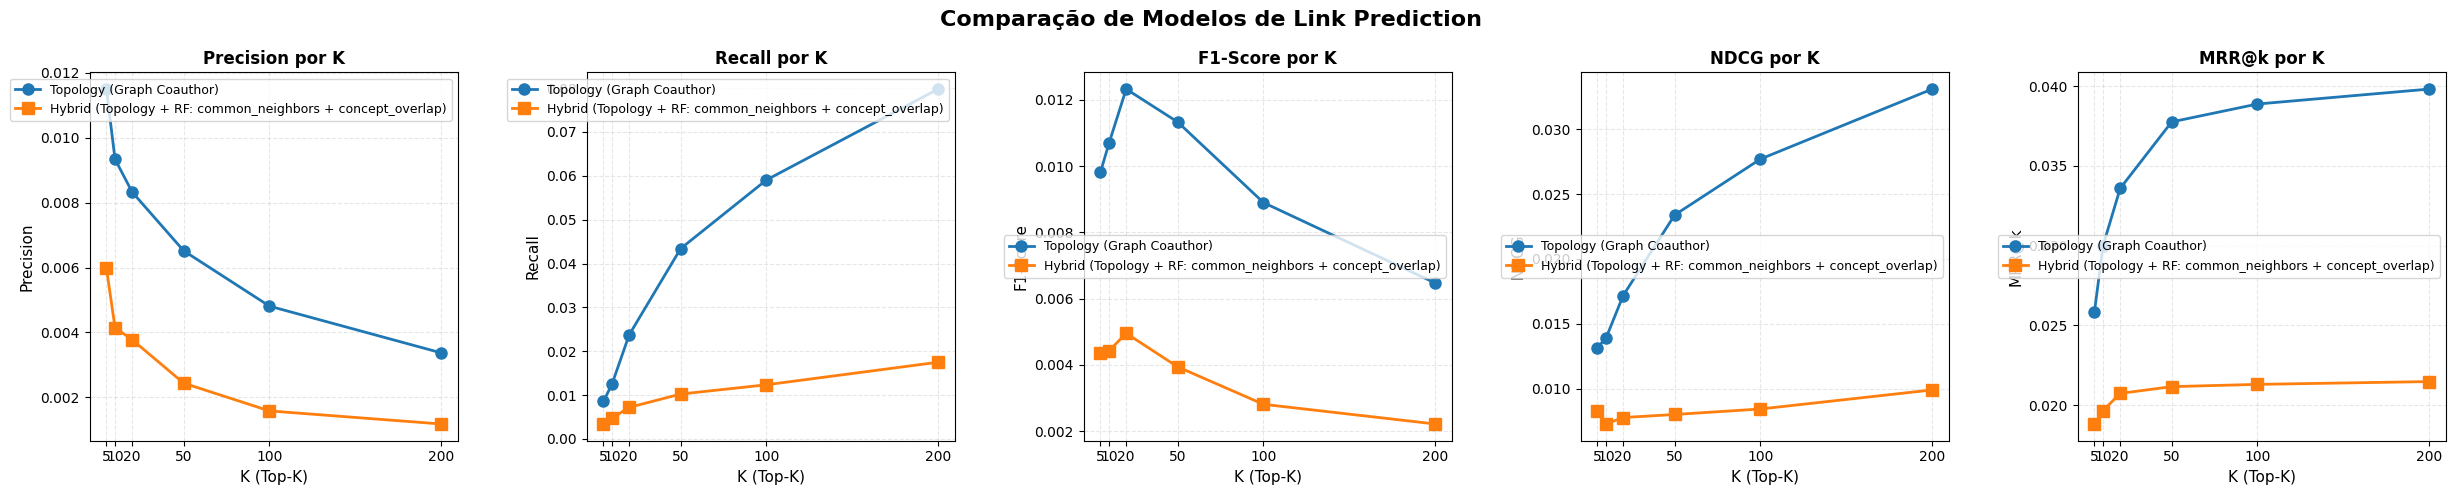

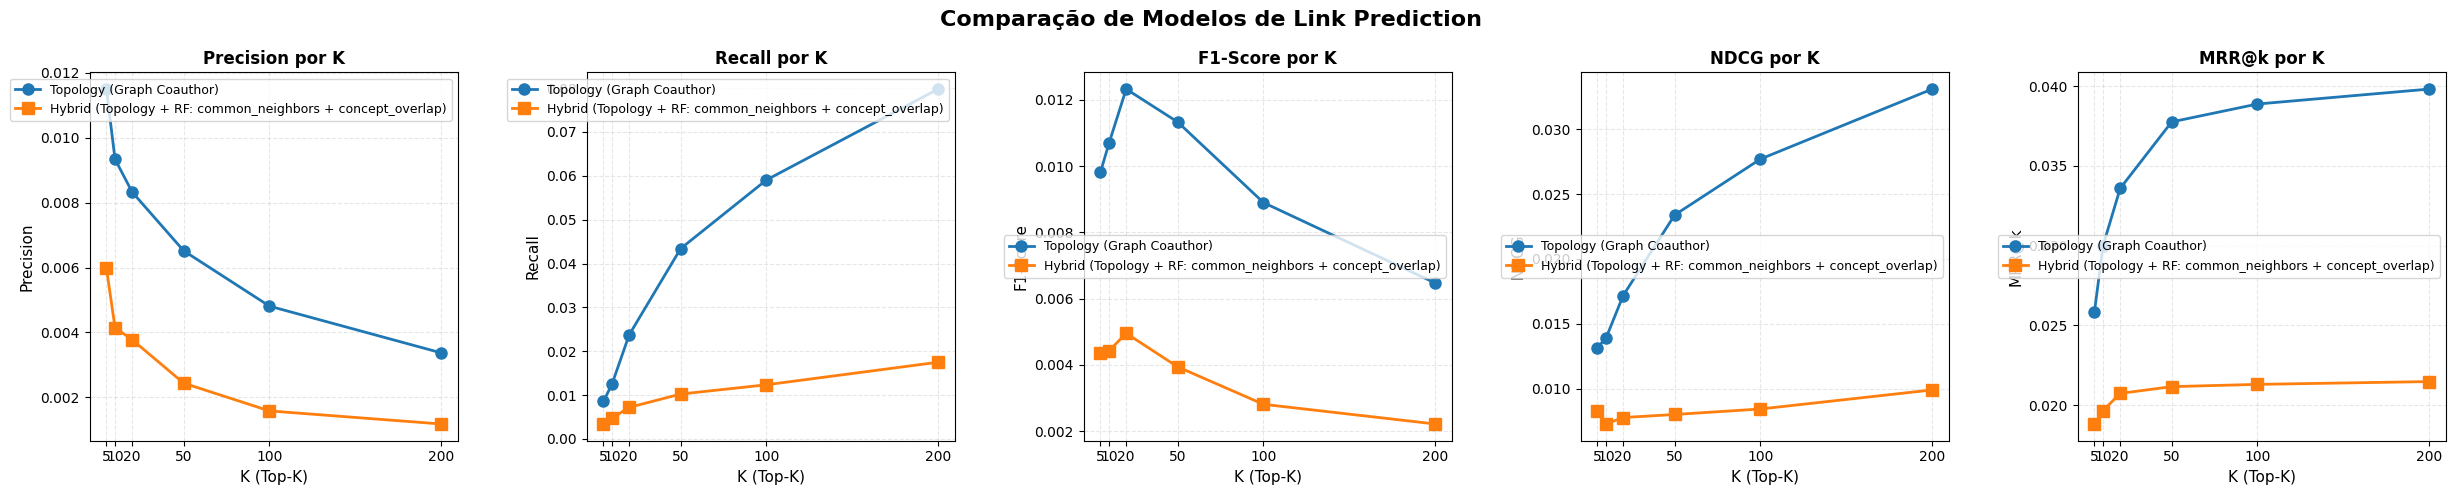

In [41]:
plot_model_comparison(metrics)